In [531]:
import autograd.numpy as np
from autograd import elementwise_grad
import numpy.linalg as la
from scipy.sparse import spdiags

import matplotlib.pyplot as plt
colors = [(0,0.4,1),(1,0.7,0.3),(0.2,0.7,0.2),(0.8,0,0.2),(0.5,0.3,.9)]

In [532]:
# Parameters
eta = 6.0
gamma = 1.0

t_max = 4
c = 1.4 # the speed and two times the height of the wave
P = 20  # period
M = 100  # number of spatial points
N = 100 # number of temporal points

In [533]:
# Utility functions
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx

sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy

# Simple analytic Soliton

In [534]:
x, dx = grid(P, M)
u_soliton = lambda x, t: 1/2*c*sech(np.abs((x-c*t) % P - P/2))**2

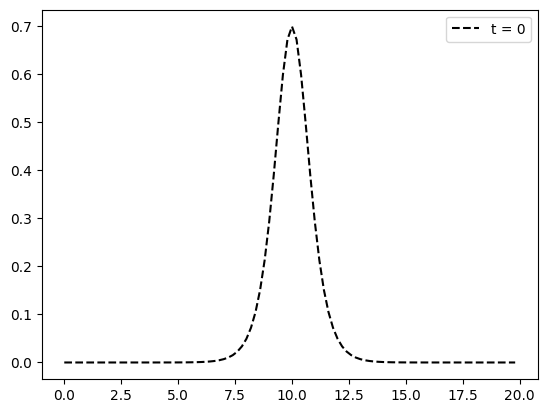

In [535]:
plt.plot(x, u_soliton(x, 0), 'k--', label='t = 0'); plt.legend();

# Non-analytic Solitons

In [536]:

g = lambda x, t: 0
f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) + g(x, t)
Df = lambda u: -np.matmul(D1, eta*np.diag(u) + gamma**2*D2)


In [537]:
# Utility functions
def difference_matrices(P, M):
    dx = P/M
    e = np.ones(M) # unit vector of length M
    # 1st order central difference matrix:
    D1 = .5/dx*spdiags([e,-e,e,-e], np.array([-M+1,-1,1,M-1]), M, M).toarray()
    # 2nd order central difference matrix:
    D2 = 1/dx**2*spdiags([e,e,-2*e,e,e], np.array([-M+1,-1,0,1,M-1]), M, M).toarray()
    return D1, D2

def midpoint_method(u, un, t ,f ,Df ,dt ,M ,tol ,max_iter):
    '''
    Integrating one step of the ODE u_t = f, from u to un,
    with the implicit midpoint method
    Using Newton's method to find un
    '''
    I = np.eye(M)
    F = lambda u_hat: 1/dt*(u_hat-u) - f((u+u_hat)/2, t+.5*dt)
    J = lambda u_hat: 1/dt*I - 1/2*Df((u+u_hat)/2)
    err = la.norm(F(un))
    it = 0
    while err > tol:
        un = un - la.solve(J(un),F(un))
        err = la.norm(F(un))
        it += 1
        if it > max_iter:
            print("Newton's method didn't converge after {} iterations".format(max_iter))
            break
    return un

In [633]:
def initial_condition_kdv(x, k1, k2, eta):
    M = x.size
    P = int((x[-1]-x[0])*M/(M-1))

    d1 = .3 # lower = .15, upper =
    d2 = .5 # lower = .4, upper =
    sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
    u0 = 0
    u0 += (-6./-eta)*2 * k1**2 * sech(np.abs(k1 * ((x+P/2-P*d1) % P - P/2)))**2
    u0 += (-6./-eta)*2 * k2**2 * sech(np.abs(k2 * ((x+P/2-P*d2) % P - P/2)))**2
    u0 = np.concatenate([u0[M:], u0[:M]], axis=-1)
    return u0

In [685]:
# Parameters
eta = 6.0
gamma = 1.0

t_max = 10
c = 2 # the speed and two times the height of the wave
P = 50  # period
M = 200  # number of spatial points
N = 200 # number of temporal points
lower, upper = .2, .7 # lower and upper bounds for wave init heights
# Grids
x, dx = grid(P, M) # spatial grid
t, dt = grid(t_max, N) # temporal grid
print(f"dx = {dx}, dt = {dt}")

dx = 0.25, dt = 0.05


In [738]:
from tqdm import trange
class DatasetTwoCollidingSolitons():
    def __init__(self, eta, gamma, t_max, P, M, N, lower, upper):
        self.eta = eta
        self.gamma = gamma
        self.t_max = t_max
        self.P = P
        self.M = M
        self.N = N
        self.lower = lower
        self.upper = upper
        self.filename = f"eta={eta}_gamma={gamma}_tmax={t_max}_P={P}_M={M}_N={N}_lower={lower}_upper={upper}"
        # format filename to not include decimals
        self.filename = self.filename.replace('.', 'p') + ".npy"
        self.data = None

        self.x, self.dx = self.grid(P, M) # spatial grid
        self.t, self.dt = self.grid(t_max, N) # temporal grid

        self.D1, self.D2 = self.difference_matrices(P,M)

        self.g = lambda x, t: 0
        self.f = lambda u, t: -np.matmul(self.D1, .5*self.eta*u**2 + self.gamma**2*np.matmul(self.D2,u)) + self.g(x, t)
        self.Df = lambda u: -np.matmul(self.D1, self.eta*np.diag(u) + self.gamma**2*self.D2)


    def grid(self, P, M):
        dx = P/M
        x = np.linspace(0, P-dx, M)
        return x, dx

    def initial_condition_kdv(self, x, k1, k2, eta):
        M = x.size
        P = int((x[-1]-x[0])*M/(M-1))

        d1 = .3
        d2 = .5
        sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
        u0 = 0
        u0 += (-6./-eta)*2 * k1**2 * sech(np.abs(k1 * ((x+P/2-P*d1) % P - P/2)))**2
        u0 += (-6./-eta)*2 * k2**2 * sech(np.abs(k2 * ((x+P/2-P*d2) % P - P/2)))**2
        u0 = np.concatenate([u0[M:], u0[:M]], axis=-1)
        return u0

    def difference_matrices(self, P, M):
        dx = P/M
        e = np.ones(M) # unit vector of length M
        # 1st order central difference matrix:
        D1 = .5/dx*spdiags([e,-e,e,-e], np.array([-M+1,-1,1,M-1]), M, M).toarray()
        # 2nd order central difference matrix:
        D2 = 1/dx**2*spdiags([e,e,-2*e,e,e], np.array([-M+1,-1,0,1,M-1]), M, M).toarray()
        return D1, D2

    def midpoint_method(self, u, un, t, f, Df , dt ,M, tol, max_iter):
        '''
        Integrating one step of the ODE u_t = f, from u to un,
        with the implicit midpoint method
        Using Newton's method to find un
        '''
        I = np.eye(M)
        F = lambda u_hat: 1/dt*(u_hat-u) - f((u+u_hat)/2, t+.5*dt)
        J = lambda u_hat: 1/dt*I - 1/2*Df((u+u_hat)/2)
        err = la.norm(F(un))
        it = 0
        while err > tol:
            un = un - la.solve(J(un),F(un))
            err = la.norm(F(un))
            it += 1
            if it > max_iter:
                print("Newton's method didn't converge after {} iterations".format(max_iter))
                break
        return un

    def create_single_sample(self, k1, k2):
        u0 = self.initial_condition_kdv(self.x, k1, k2, self.eta)
        u = np.zeros((self.N, self.M))
        u[0] = u0
        for n in range(self.N-1):
            u[n+1] = self.midpoint_method(u[n], u[n], self.t[n], self.f, self.Df, self.dt, self.M, 1e-8, 100)
        return u

    def create_dataset(self, N_samples):
        self.data = np.zeros((N_samples, self.N, self.M))
        k1 = self.lower + (self.upper-self.lower)*np.random.rand(N_samples)
        k2 = self.lower + (self.upper-self.lower)*np.random.rand(N_samples)
        for i in trange(N_samples, desc="Creating dataset", leave=True):
            self.data[i] = self.create_single_sample(k1[i], k2[i])

    def save_data(self):
        try:
            np.save(self.filename, self.data)
            print(f"Saved data to {self.filename}")
        except:
            print(f"Couldn't save data to {self.filename}")

    def load_data(self):
        try:
            self.data = np.load(self.filename)
            print(f"Loaded data from {self.filename}")
        except:
            print(f"Couldn't load data from {self.filename}")

In [739]:
twosolotions = DatasetTwoCollidingSolitons(eta, gamma, t_max, P, M, N, lower, upper)
twosolotions.create_dataset(5)

Creating dataset: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


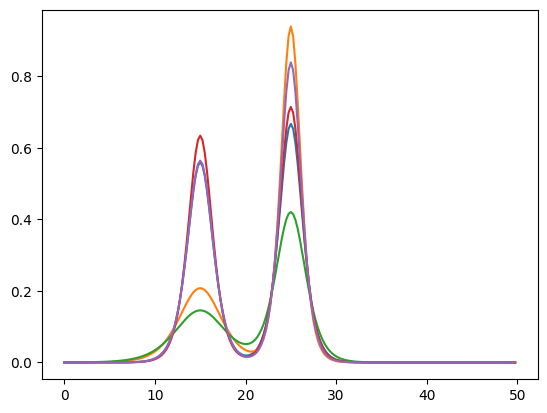

In [740]:
for i in range(5):
    plt.plot(twosolotions.x, twosolotions.data[i,0])

In [741]:
twosolotions.save_data()

Saved data to eta=6p0_gamma=1p0_tmax=10_P=50_M=200_N=200_lower=0p2_upper=0p7.npy


In [742]:
twosolotions2 = DatasetTwoCollidingSolitons(eta, gamma, t_max, P, M, N, lower, upper)
twosolotions2.load_data()

Loaded data from eta=6p0_gamma=1p0_tmax=10_P=50_M=200_N=200_lower=0p2_upper=0p7.npy


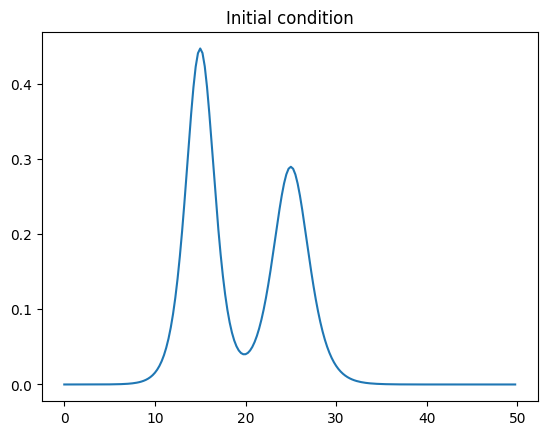

In [743]:

k1 = lower + (upper-lower)*np.random.rand()
k2 = lower + (upper-lower)*np.random.rand()

D1, D2 = difference_matrices(P,M)
u0 = initial_condition_kdv(x, k1, k2, eta)
plt.plot(x, u0); plt.title('Initial condition');

CPU times: user 8.82 s, sys: 636 ms, total: 9.46 s
Wall time: 1.4 s


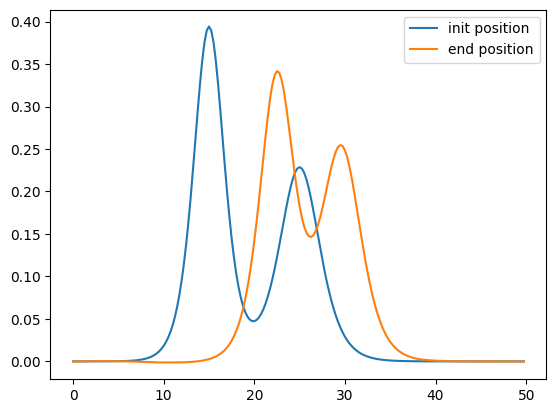

In [714]:
%%time
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0
# The implicit midpoint method:
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 10)
plt.plot(x, u[0], label="init position");
plt.plot(x, u[-1], label="end position");
plt.legend();

MovieWriter ffmpeg unavailable; using Pillow instead.


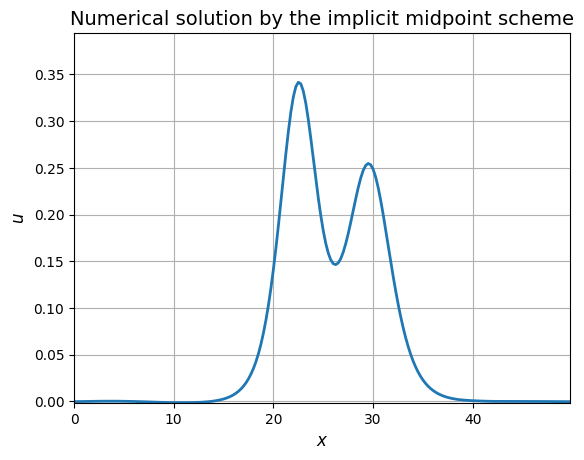

In [715]:
from matplotlib import animation, rc
rc('animation', html='jshtml')
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim((x[0], x[-1]))
ax.set_ylim((u.min(), u.max()))
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$u$', fontsize=12)
ax.set_title('Numerical solution by the implicit midpoint scheme', fontsize=14)
ax.grid()
def init():
    line.set_data([], [])
    return (line,)
def animate(i):
    line.set_data(x, u[i,:])
    return (line,)
ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=u.shape[0], interval=200, blit=True)
ani.save('implicit_midpoint.gif', fps=30)

(0.0, 0.01)

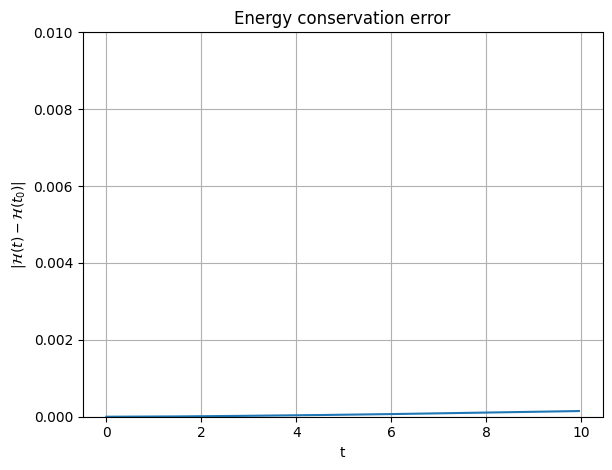

In [716]:
import torch
import scipy.sparse
def energy_conservation(u, dx, eta, gamma):
    M = u.size(-1)
    device = u.device
    e = np.ones(M)
    Dp = .5 / dx * spdiags([e, -e, e, -e], np.array([-M + 1, -1, 1, M - 1]), M, M).toarray()
    Dp = torch.tensor(Dp, dtype=torch.float32, device=device)

    H = lambda u: dx*torch.sum(-1/6*eta*u**3 + (.5*gamma**2*torch.matmul(Dp,u.transpose(1, 2)).transpose(1, 2)**2), dim=2)
    Ht = H(u)
    return torch.abs(Ht - Ht[:, 0, None])
H = energy_conservation(torch.tensor(u, dtype=torch.float32, device='cpu').unsqueeze(0), dx, eta, gamma)
plt.plot(t, H[0].numpy())
plt.xlabel('t')
plt.ylabel('$|\mathcal{H}(t) - \mathcal{H}(t_0)|$')
plt.title('Energy conservation error')
plt.grid()
plt.tight_layout()
plt.ylim((0, 0.01))